<a href="https://colab.research.google.com/github/Aminur12-tech/Aminur/blob/main/Banana_Disease_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import necessary libraries
import cv2
import numpy as np
import os
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from scipy import stats

In [ ]:
# Define image size
SIZE = 150

# Define labels and corresponding folder names
labels = ['BACTERIAL_SOFT_ROT', 'BANANA_APHIDS', 'BANANA_FRUIT_SCARRING_BEETLE',
          'BLACK_SIGATOKA', 'PANAMA_DISEASE', 'PSEUDOSTEM_WEEVIL', 'YELLOW_SIGATOKA']

# Initialize lists for images, labels, and HSV features
images = []
encoded_labels = []
hsv_features = []

# Load images, encode labels, and extract HSV features
for label_idx, label in enumerate(labels):
    folder_path = f'/content/drive/MyDrive/dataset for bca/train/{label}'
    for image_file in os.listdir(folder_path):
        image = cv2.imread(os.path.join(folder_path, image_file))
        if image is not None:
            # Define the lower and upper bounds for green color in HSV
            lower_green = np.array([40, 40, 40])
            upper_green = np.array([80, 255, 255])

            # Create a mask and apply to the image
            mask = cv2.inRange(image, lower_green, upper_green)
            image = cv2.bitwise_and(image, image, mask=mask)

            # Resize image and add to list
            image = cv2.resize(image, (SIZE, SIZE))
            images.append(image)
            encoded_labels.append(label_idx)
            hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
            hsv_features.append(hsv_image.flatten())


In [ ]:
# Convert lists to arrays
images = np.array(images)
encoded_labels = np.array(encoded_labels)
hsv_features = np.array(hsv_features)

# One-hot encode labels
encoded_labels = to_categorical(encoded_labels)


DESCRIPTIVE STATISTICS


In [ ]:
# Descriptive Statistics

# Convert images to HSV and flatten to analyze color distribution
all_hsv_images = [cv2.cvtColor(img, cv2.COLOR_BGR2HSV).flatten() for img in images]
all_hsv_images = np.array(all_hsv_images)

# Descriptive statistics for each HSV channel
hue_mean = np.mean(all_hsv_images[:, :SIZE*SIZE])
hue_median = np.median(all_hsv_images[:, :SIZE*SIZE])
hue_std = np.std(all_hsv_images[:, :SIZE*SIZE])
hue_skew = stats.skew(all_hsv_images[:, :SIZE*SIZE])
hue_kurtosis = stats.kurtosis(all_hsv_images[:, :SIZE*SIZE])

sat_mean = np.mean(all_hsv_images[:, SIZE*SIZE:2*SIZE*SIZE])
sat_median = np.median(all_hsv_images[:, SIZE*SIZE:2*SIZE*SIZE])
sat_std = np.std(all_hsv_images[:, SIZE*SIZE:2*SIZE*SIZE])
sat_skew = stats.skew(all_hsv_images[:, SIZE*SIZE:2*SIZE*SIZE])
sat_kurtosis = stats.kurtosis(all_hsv_images[:, SIZE*SIZE:2*SIZE*SIZE])

val_mean = np.mean(all_hsv_images[:, 2*SIZE*SIZE:])
val_median = np.median(all_hsv_images[:, 2*SIZE*SIZE:])
val_std = np.std(all_hsv_images[:, 2*SIZE*SIZE:])
val_skew = stats.skew(all_hsv_images[:, 2*SIZE*SIZE:])
val_kurtosis = stats.kurtosis(all_hsv_images[:, 2*SIZE*SIZE:])


In [ ]:
# Print descriptive statistics
print("Hue - Mean:", hue_mean, "\n Median:", hue_median, "\n Std Dev:", hue_std, "\n Skew:", hue_skew, "\n Kurtosis:", hue_kurtosis)
print("\nSaturation - Mean:", sat_mean, "\n Median:", sat_median, "\n Std Dev:", sat_std, "\n Skew:", sat_skew, "\n Kurtosis:", sat_kurtosis)
print("\nValue - Mean:", val_mean, "\n Median:", val_median, "\n Std Dev:", val_std, "\n Skew:", val_skew, "\n Kurtosis:", val_kurtosis)

# Analyze the class distribution
unique, counts = np.unique(encoded_labels.argmax(axis=1), return_counts=True)
class_distribution = dict(zip(labels, counts))
print("Class Distribution:", class_distribution)


Hue - Mean: 6.056643144677897 
 Median: 0.0 
 Std Dev: 25.36302819860552 
 Skew: [8.0074116  4.51521362 4.02394962 ... 6.94942208 5.64508812 4.39926282] 
 Kurtosis: [95.42334232 18.93795888 16.21144618 ... 60.71539577 31.73371815
 20.77926833]

Saturation - Mean: 10.9120053504953 
 Median: 0.0 
 Std Dev: 32.88530074251653 
 Skew: [8.22501026 5.31811803 4.1255705  ... 8.95164987 5.28602572 4.28694199] 
 Kurtosis: [ 87.56539655  29.42576763  19.29819099 ... 104.66922013  27.8659037
  19.84455225]

Value - Mean: 6.328862565461543 
 Median: 0.0 
 Std Dev: 25.000488594565425 
 Skew: [7.20050628 7.69019545 5.12951572 ... 8.58496328 6.62090304 3.76977359] 
 Kurtosis: [53.37322764 63.62314871 32.61471589 ... 94.95285191 47.61307569
 14.82720079]
Class Distribution: {'BACTERIAL_SOFT_ROT': 249, 'BANANA_APHIDS': 252, 'BANANA_FRUIT_SCARRING_BEETLE': 252, 'BLACK_SIGATOKA': 252, 'PANAMA_DISEASE': 252, 'PSEUDOSTEM_WEEVIL': 252, 'YELLOW_SIGATOKA': 252}


APPLYING RANDOM FOREST

In [ ]:
# Split the data into training and validation sets
x_train, x_val, y_train, y_val, hsv_train, hsv_val = train_test_split(images, encoded_labels, hsv_features, test_size=0.1, random_state=101)

# Flatten x_train to match the shape of hsv_train
x_train_flattened = x_train.reshape((x_train.shape[0], -1))
hsv_features_train = np.concatenate((x_train_flattened, hsv_train), axis=1)

# Repeat the same for x_val
x_val_flattened = x_val.reshape((x_val.shape[0], -1))
hsv_features_val = np.concatenate((x_val_flattened, hsv_val), axis=1)

In [ ]:

# Define and train the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(hsv_features_train, y_train)

# Evaluate the Random Forest classifier
rf_train_accuracy = accuracy_score(y_train, rf_classifier.predict(hsv_features_train))
rf_val_accuracy = accuracy_score(y_val, rf_classifier.predict(hsv_features_val))

In [ ]:
print("Random Forest Classifier Train Accuracy:", rf_train_accuracy)
print("Random Forest Classifier Validation Accuracy:", rf_val_accuracy)


Random Forest Classifier Train Accuracy: 0.9343434343434344
Random Forest Classifier Validation Accuracy: 0.3446327683615819


In [ ]:
# Get predictions and generate classification reports
train_predictions = rf_classifier.predict(hsv_features_train)
val_predictions = rf_classifier.predict(hsv_features_val)

train_classification_report = classification_report(y_train, train_predictions)
val_classification_report = classification_report(y_val, val_predictions)

# Print classification reports
print("Classification Report for Training Set:\n", train_classification_report)
print("\nClassification Report for Validation Set:\n", val_classification_report)

Classification Report for Training Set:
               precision    recall  f1-score   support

           0       1.00      0.77      0.87       224
           1       1.00      0.94      0.97       232
           2       1.00      1.00      1.00       227
           3       1.00      0.96      0.98       224
           4       1.00      0.92      0.96       221
           5       1.00      0.95      0.97       223
           6       1.00      1.00      1.00       233

   micro avg       1.00      0.93      0.97      1584
   macro avg       1.00      0.93      0.96      1584
weighted avg       1.00      0.93      0.96      1584
 samples avg       0.93      0.93      0.93      1584


Classification Report for Validation Set:
               precision    recall  f1-score   support

           0       0.60      0.12      0.20        25
           1       1.00      0.65      0.79        20
           2       1.00      0.76      0.86        25
           3       1.00      0.32      0.49    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


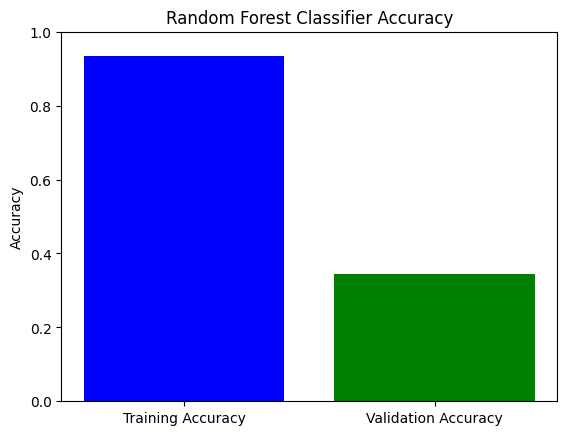

In [ ]:
# Plotting accuracy values
labels_acc = ['Training Accuracy', 'Validation Accuracy']
accuracy_values = [rf_train_accuracy, rf_val_accuracy]

plt.bar(labels_acc, accuracy_values, color=['blue', 'green'])
plt.title('Random Forest Classifier Accuracy')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Set y-axis limit to 0-1 for accuracy values
plt.show()

In [ ]:
# Function to predict disease from a single image
def predict_disease(image_path):
    # Load image
    image = cv2.imread(image_path)
    if image is None:
        print("Image not found.")
        return

    # Define the lower and upper bounds for green color in HSV (used in training)
    lower_green = np.array([40, 40, 40])
    upper_green = np.array([80, 255, 255])

    # Create a mask and apply to the image
    mask = cv2.inRange(image, lower_green, upper_green)
    image = cv2.bitwise_and(image, image, mask=mask)

    # Resize image
    image = cv2.resize(image, (SIZE, SIZE))

    # Convert to HSV and flatten
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hsv_features = hsv_image.flatten()

    # Flatten the image itself
    image_flattened = image.flatten()

    # Concatenate flattened image and HSV features
    combined_features = np.concatenate((image_flattened, hsv_features)).reshape(1, -1)

    # Predict with the Random Forest classifier
    prediction = rf_classifier.predict(combined_features)
    predicted_label = labels[np.argmax(prediction)]

    print("Predicted Disease:", predicted_label)

# Example usage
image_path = '/content/drive/MyDrive/dataset for bca/test/BACTERIAL_SOFT_ROT/SOFT_ROT  A1 (15).jpg'  # Replace with the path to the test image
predict_disease(image_path)

Predicted Disease: BACTERIAL_SOFT_ROT
